In [1807]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [1808]:
m = 500                          # 5, 10, 20, 50, 100, 500

In [1809]:
desired_num = 1000

In [1810]:
tr_i = 0
tr_j = int(desired_num/2)
tr_k = desired_num

tr_i, tr_j, tr_k

(0, 500, 1000)

# Generate dataset

In [1811]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [1812]:
x = np.zeros((5000,2))

In [1813]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [1814]:
x[idx[0]][0], x[idx[5]][5] 

(array([5.14957125, 4.78451422]), array([0.87756167, 0.00457805]))

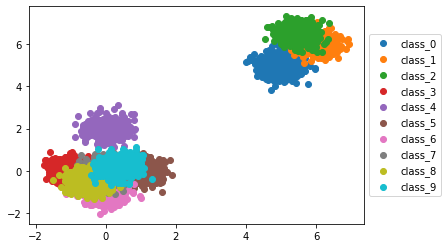

In [1815]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [1816]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [1817]:
np.unique(bg_idx).shape

(3513,)

In [1818]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [1819]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[1.63261967, 1.69552644]]))

In [1820]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [1821]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[3.93071885, 3.03840862]]))

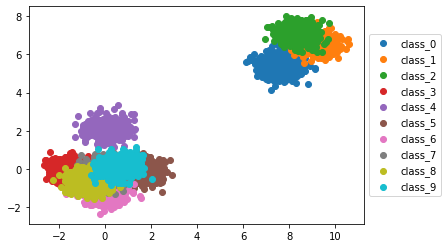

In [1822]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [1823]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [1824]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)

a = []
for i in range(m):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
background 9 present at 2
background 3 present at 3
background 5 present at 4
background 7 present at 5
background 6 present at 6
background 5 present at 7
background 3 present at 8
background 5 present at 9
background 4 present at 10
background 7 present at 11
background 4 present at 12
background 3 present at 13
background 9 present at 14
background 6 present at 15
background 6 present at 16
background 3 present at 17
background 3 present at 18
background 5 present at 19
background 4 present at 20
background 4 present at 21
background 9 present at 22
background 8 present at 23
background 3 present at 24
background 7 present at 25
background 6 present at 26
background 8 present at 27
background 3 present at 28
background 7 present at 29
background 8 present at 30
background 7 present at 31
background 7 present at 32
background 5 present at 33
background 9 present at 34
background 6 present at 35
background 4 present at 36
background 

In [1825]:
np.reshape(a,(2*m,1))

array([[ 1.52560273e+00],
       [-1.29848805e-01],
       [-4.22650796e-01],
       [-1.20033130e+00],
       [ 2.34349307e-01],
       [-2.78664796e-01],
       [-9.86087689e-01],
       [-7.51232458e-01],
       [ 1.37297554e+00],
       [-3.76733075e-01],
       [-8.84692079e-01],
       [-1.11551995e-01],
       [ 3.23086410e-01],
       [-1.23774128e+00],
       [ 1.37297554e+00],
       [-3.76733075e-01],
       [-1.37994224e+00],
       [-1.86927689e-02],
       [ 1.18729176e+00],
       [-1.43385686e-01],
       [ 1.08414750e+00],
       [ 2.21424613e+00],
       [ 3.07773579e-01],
       [ 5.11134472e-01],
       [-5.80062748e-01],
       [ 2.56861924e+00],
       [-1.57480355e+00],
       [ 1.37864198e-01],
       [ 8.78834768e-01],
       [-3.18178197e-01],
       [ 5.58625839e-02],
       [-1.37825691e+00],
       [ 3.52658712e-01],
       [-1.71500720e+00],
       [-7.59374170e-01],
       [-4.37189615e-03],
       [-2.04596416e+00],
       [-2.96574324e-01],
       [ 6.6

In [1826]:

mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [1827]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images.shape

(1000, 1000)

In [1828]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((1000, 1000),
 array([ 5.05033874e-01, -6.51442375e-01, -2.59955349e-02, -1.54374402e+00,
         4.78358582e-01, -1.25389275e+00,  5.00445443e-01,  1.71315143e+00,
        -7.26036664e-01, -6.82400884e-01,  3.40706957e-01,  2.88995008e-02,
         7.16311356e-01, -1.42621688e-01, -1.42817136e+00, -3.82902021e-01,
         1.24086849e+00, -1.47454038e-01,  7.02373522e-01,  2.96185609e-01,
         2.25544289e-01,  1.98923115e-01, -1.35092213e-01,  2.32146152e+00,
         4.70651371e-01, -1.70530655e+00, -4.42421792e-02, -8.58447371e-01,
         6.20891493e-01, -8.65683419e-02, -1.00159206e+00, -6.18125657e-01,
        -2.28311639e+00, -9.65179595e-02,  2.42914057e-01, -1.06097518e+00,
         5.55567480e-01, -1.08092273e+00,  1.06767904e-01,  6.90941118e-01,
        -1.81042807e+00, -4.21543195e-01,  3.45167982e-01,  1.91607747e+00,
        -1.44649678e+00,  3.53085288e-01,  3.65159740e-01, -6.72137948e-01,
         1.22158179e+00, -2.29521265e-01, -3.98487287e-01, -1.57587090e-0

In [1829]:
for j in range(m):
  print(mosaic_list_of_images[0][2*j:2*j+2])
  

[ 0.50503387 -0.65144237]
[-0.02599553 -1.54374402]
[ 0.47835858 -1.25389275]
[0.50044544 1.71315143]
[-0.72603666 -0.68240088]
[0.34070696 0.0288995 ]
[ 0.71631136 -0.14262169]
[-1.42817136 -0.38290202]
[ 1.24086849 -0.14745404]
[0.70237352 0.29618561]
[0.22554429 0.19892312]
[-0.13509221  2.32146152]
[ 0.47065137 -1.70530655]
[-0.04424218 -0.85844737]
[ 0.62089149 -0.08656834]
[-1.00159206 -0.61812566]
[-2.28311639 -0.09651796]
[ 0.24291406 -1.06097518]
[ 0.55556748 -1.08092273]
[0.1067679  0.69094112]
[-1.81042807 -0.42154319]
[0.34516798 1.91607747]
[-1.44649678  0.35308529]
[ 0.36515974 -0.67213795]
[ 1.22158179 -0.22952126]
[-0.39848729 -0.15758709]
[-1.71963958 -0.15407132]
[ 0.20179406 -0.01948999]
[-0.17037075 -0.51969469]
[-2.29570869 -0.14652342]
[-1.21373644  0.2181639 ]
[ 1.76844163 -0.1397818 ]
[-1.06409105  0.04438987]
[-0.4441898   2.69172256]
[0.320152   1.70145171]
[-0.70852583 -1.28478294]
[-0.61407994 -1.32199884]
[1.27399796 0.10715221]
[-1.66469081 -0.5871587 ]
[-

In [1830]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number, m):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.zeros(m) #np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([2], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(m):
      if j == give_pref:
        img = img + mosaic_dataset[i][2*j:2*j+2]*dataset_number/m   #2 is data dim
      else :
        img = img + mosaic_dataset[i][2*j:2*j+2]*(m-dataset_number)/((m-1)*m)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [1831]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr_j], mosaic_label[0:tr_j], fore_idx[0:tr_j] , 1, m)


test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr_j : tr_k], mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] , m, m)

number of correct averaging happened for dataset 1 is 500
the averaging are done as  [0. 0. 0. 1. 0. 3. 1. 0. 0. 0. 0. 1. 1. 0. 0. 2. 1. 2. 1. 0. 1. 0. 0. 1.
 1. 1. 2. 0. 3. 0. 1. 0. 0. 0. 2. 1. 0. 1. 0. 1. 3. 1. 3. 0. 0. 1. 2. 2.
 1. 1. 1. 2. 0. 0. 0. 1. 4. 1. 3. 0. 2. 1. 2. 0. 0. 1. 3. 0. 0. 0. 1. 1.
 2. 2. 2. 0. 2. 1. 0. 0. 0. 5. 1. 3. 1. 0. 1. 1. 0. 3. 0. 0. 0. 0. 2. 1.
 0. 1. 1. 1. 0. 1. 0. 2. 0. 2. 1. 1. 1. 2. 2. 1. 1. 0. 4. 0. 2. 3. 0. 1.
 0. 1. 1. 1. 1. 4. 0. 1. 2. 0. 1. 2. 2. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 2.
 2. 0. 3. 1. 1. 2. 0. 0. 2. 3. 2. 0. 4. 2. 2. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 2. 1. 3. 0. 3. 1. 2. 0. 3. 1. 1. 0. 0. 0. 1. 1. 1. 3. 3. 1.
 2. 3. 2. 0. 1. 2. 0. 2. 0. 2. 3. 2. 2. 0. 1. 1. 1. 0. 1. 0. 1. 0. 2. 2.
 0. 0. 2. 1. 1. 2. 0. 3. 0. 1. 0. 1. 0. 0. 3. 1. 3. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 2. 1. 1. 2. 0. 1. 0. 0. 2. 1. 4. 1. 0. 2. 3. 0. 1. 2. 1. 1. 1. 1.
 0. 0. 1. 0. 2. 0. 0. 2. 0. 0. 2. 4. 0. 2. 1. 3. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 3. 1. 0. 1. 1. 0. 4. 1. 2. 0.

In [1832]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)
# avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)


test_dataset = torch.stack(test_dataset, axis = 0)
# test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/500')

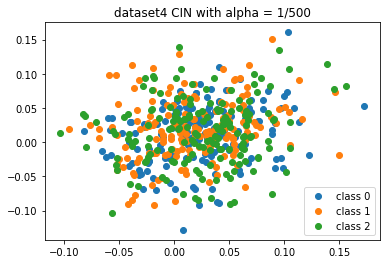

In [1833]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

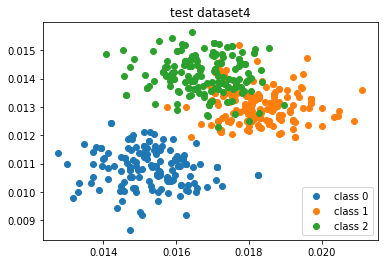

In [1834]:
x1 = (test_dataset).numpy() / m
y1 = np.array(labels)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [1835]:
test_dataset[0:10]/m

tensor([[0.0153, 0.0150],
        [0.0140, 0.0112],
        [0.0128, 0.0114],
        [0.0180, 0.0134],
        [0.0164, 0.0137],
        [0.0175, 0.0135],
        [0.0144, 0.0094],
        [0.0148, 0.0115],
        [0.0179, 0.0129],
        [0.0176, 0.0139]], dtype=torch.float64)

In [1836]:
test_dataset = test_dataset/m
test_dataset[0:10]

tensor([[0.0153, 0.0150],
        [0.0140, 0.0112],
        [0.0128, 0.0114],
        [0.0180, 0.0134],
        [0.0164, 0.0137],
        [0.0175, 0.0135],
        [0.0144, 0.0094],
        [0.0148, 0.0115],
        [0.0179, 0.0129],
        [0.0176, 0.0139]], dtype=torch.float64)

In [1837]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [1838]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([-0.0226, -0.0282], dtype=torch.float64)

In [1839]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [1840]:
testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [1841]:
testdata_11 = MosaicDataset(test_dataset, labels )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [1842]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,3)
        # self.linear2 = nn.Linear(50,10)
        # self.linear3 = nn.Linear(10,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = (self.linear1(x))

        return x

In [1843]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [1844]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [1845]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi
    

In [1846]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_11]

In [1847]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 1.097
epoch: [1] loss: 1.098
epoch: [201] loss: 1.095
epoch: [401] loss: 1.094
epoch: [601] loss: 1.093
epoch: [801] loss: 1.092
Finished Training
Accuracy of the network on the 500 train images: 36.60 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  183 total  500
Accuracy of the network on the 500 test dataset 1: 36.60 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  173 total  500
Accuracy of the network on the 500 test dataset 2: 34.60 %
--------------------------------------------------------------------------------


In [1848]:
%matplotlib inline

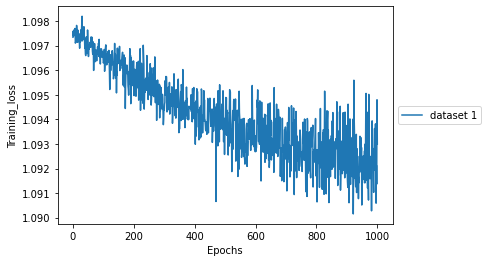

In [1849]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))